## Install libraries

In [6]:
%%capture
!sudo apt update && sudo apt install python-opengl
!sudo apt update && sudo apt install xvfb
!pip install gym-notebook-wrapper stable-baselines[mpi] box2d box2d-kengz pyvirtualdisplay pyglet
# !pip install gym
!pip install wandb
!pip install pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq

In [7]:
%%capture
!git clone https://github.com/openai/gym.git
%cd gym
!pip install -e .
!pip install stable-baselines[mpi]
!pip install stable-baselines3[extra]

## Import useful libraries

In [8]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import gnwrapper
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)
import glob
import io
import os
import cv2
import base64
from collections import deque
from datetime import datetime
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import wandb
import time

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Get a modified vsersion of Car Racing from github official site 

In [9]:
!git clone https://github.com/AGiannoutsos/car_racer_gym.git
%cd car_racer_gym

from car_racing import CarRacingDiscrete, CarRacing 

Cloning into 'car_racer_gym'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 36 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (36/36), done.
/content/gym/car_racer_gym


## Quick example with CarRacing

Track generation: 1171..1468 -> 297-tiles track


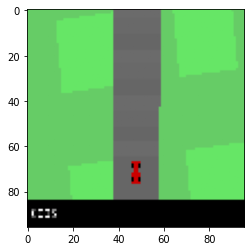

In [10]:
# from gym.envs.box2d import CarRacing
env = gnwrapper.Animation(CarRacingDiscrete())
env = CarRacingDiscrete()

env.reset()
env.render()
im = env.render("state_pixels")

def state_image_preprocess(state_image):
    # crop image
    # state_image = state_image[0:84, :, :]
    state_image = state_image.transpose((2,0,1))
    # to torch
    state_image = np.ascontiguousarray(state_image, dtype=np.float32) / 255
    state_image = torch.from_numpy(state_image)
    return state_image.unsqueeze(0).to(device)

# plt.imshow(im)
state_image_preprocess(im).shape
plt.imshow(state_image_preprocess(im).cpu().squeeze(0).permute(1, 2, 0).numpy())

## Custom Callback Class

### DQN callback

In [11]:
from stable_baselines3.common.callbacks import BaseCallback

class DQNCustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug
    """
    def __init__(self, verbose=0):
        super(DQNCustomCallback, self).__init__(verbose)
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env = None  # type: Union[gym.Env, VecEnv, None]
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = None  # type: Dict[str, Any]
        # self.globals = None  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger = None  # stable_baselines3.common.logger
        # # Sometimes, for event callback, it is useful
        # # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]
        self.episodes = 0
        self.total_episode_reward = 0

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        # update commulative reward to log at the end of every episode
        self.total_episode_reward += self.locals["reward"]
        # at the end of every episode
        if self.locals["done"][0]:

            # log the reward value if its time to not log 2 times
            if self.episodes % self.locals["log_interval"] != 0: 
                wandb.log({"reward_per_episode": self.total_episode_reward})

            # if log interval has passed
            if self.episodes % self.locals["log_interval"] == 0:
                # log at wandb and print the last video
                # Save your model and optimizer
                self.model.save(MODEL_SAVE_NAME)
                # Save as artifact for version control.
                artifact = wandb.Artifact(MODEL_SAVE_NAME, type='model')
                artifact.add_file(MODEL_SAVE_NAME+".zip")
                wandb.log_artifact(artifact)
                wandb.log({"reward_per_episode": self.total_episode_reward})


                mp4list = glob.glob('video/*.mp4')
                print(mp4list)
                if len(mp4list) > 0:
                    print(len(mp4list))
                    mp4 = mp4list[-1]
                    video = io.open(mp4, 'r+b').read()
                    encoded = base64.b64encode(video)

                    # log gameplay video in wandb
                    wandb.log({"gameplays": wandb.Video(mp4, fps=4, format="gif")})

                    # display gameplay video
                    ipythondisplay.clear_output(wait=True)
                    ipythondisplay.display(HTML(data='''<video alt="" autoplay 
                                loop controls style="height: 400px;">
                                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                            </video>'''.format(encoded.decode('ascii'))))
                    print("Episode ", self.episodes)
            self.episodes += 1
            self.total_episode_reward = 0

        
        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        pass

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass



### PPO callback

In [12]:
class PPOCustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug
    """
    def __init__(self, verbose=0):
        super(PPOCustomCallback, self).__init__(verbose)
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env = None  # type: Union[gym.Env, VecEnv, None]
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = None  # type: Dict[str, Any]
        # self.globals = None  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger = None  # stable_baselines3.common.logger
        # # Sometimes, for event callback, it is useful
        # # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]
        self.episodes = 0
        self.total_episode_reward = 0

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        # update commulative reward to log at the end of every episode
        self.total_episode_reward += self.locals["rewards"]
        # at the end of every episode
        if self.locals["dones"][0]:

            # log the reward value if its time to not log 2 times
            if self.episodes % self.locals["log_interval"] != 0: 
                wandb.log({"reward_per_episode": self.total_episode_reward})

            # if log interval has passed
            if self.episodes % self.locals["log_interval"] == 0:
                # log at wandb and print the last video
                # Save your model and optimizer
                self.model.save(MODEL_SAVE_NAME)
                # Save as artifact for version control.
                artifact = wandb.Artifact(MODEL_SAVE_NAME, type='model')
                artifact.add_file(MODEL_SAVE_NAME+".zip")
                wandb.log_artifact(artifact)
                wandb.log({"reward_per_episode": self.total_episode_reward})


                mp4list = glob.glob('video/*.mp4')
                print(mp4list)
                if len(mp4list) > 0:
                    print(len(mp4list))
                    mp4 = mp4list[-1]
                    video = io.open(mp4, 'r+b').read()
                    encoded = base64.b64encode(video)

                    # log gameplay video in wandb
                    wandb.log({"gameplays": wandb.Video(mp4, fps=4, format="gif")})

                    # display gameplay video
                    ipythondisplay.clear_output(wait=True)
                    ipythondisplay.display(HTML(data='''<video alt="" autoplay 
                                loop controls style="height: 400px;">
                                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                            </video>'''.format(encoded.decode('ascii'))))
                    print("Episode ", self.episodes)
            self.episodes += 1
            self.total_episode_reward = 0

        
        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        pass

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass

## Training

### PPO

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3.common.env_util import make_vec_env



NUM_OF_STEPS        = 500
NUM_OF_EPISODES     = 4
LOG_INTERVAL        = 2
BUFFER_SIZE         = 10000
LEARNING_STARTS     = 1000
WANDB_ID            = "test_logging2"
WNDB_NAME           = "test_logging2"
LOAD_SAVED_MODEL    = False
MODEL_SAVE_NAME     = "test_modell"
SAVED_MODEL_VERSION = "latest"

# wnadb api key: 00d5bfbd342bb73d5aaf4f2833436d20457ef040
os.environ["WANDB_ENTITY"]  = "andreas_giannoutsos"
os.environ["WANDB_PROJECT"] = "gym_car_racer"
os.environ["WANDB_RESUME"]  = "allow"
wandb.init(resume=WANDB_ID)
wandb.run.name = WNDB_NAME

# env = CarRacing(NUM_OF_STEPS)
env = gym.wrappers.Monitor(CarRacing(NUM_OF_STEPS), './video', force=True)
# env = make_vec_env(CarRacing, n_envs=4)


# Load model
if LOAD_SAVED_MODEL:
    try:
        model_artifact = wandb.use_artifact(MODEL_SAVE_NAME+':'+SAVED_MODEL_VERSION, type='model')
        artifact_dir = model_artifact.download()
        PPOmodel = PPO.load(artifact_dir+"/"+MODEL_SAVE_NAME, env=env)
        print("LOAD SAVED PPΟ MODEL")

    except:
        print("NO MODEL FOUND")
else:
    if 'PPOmodel' not in globals():
        PPOmodel = PPO(CnnPolicy, env, verbose=1)
        print("INITIALIZE NEW PPO MODEL")
    else:
        PPOmodel = PPO.load(MODEL_SAVE_NAME, env=env)
        print("CONTINUE PPO MODEL TRAINING")


# Train model
PPOmodel.learn(total_timesteps=NUM_OF_STEPS*NUM_OF_EPISODES, log_interval=LOG_INTERVAL, callback=PPOCustomCallback())
PPOmodel.save(MODEL_SAVE_NAME)

### DQN

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.dqn import CnnPolicy

NUM_OF_STEPS        = 500
NUM_OF_EPISODES     = 4
LOG_INTERVAL        = 2
BUFFER_SIZE         = 10000
LEARNING_STARTS     = 1000
WANDB_ID            = "test_logging2"
WNDB_NAME           = "test_logging2"
LOAD_SAVED_MODEL    = False
MODEL_SAVE_NAME     = "test_modell"
SAVED_MODEL_VERSION = "latest"

# wnadb api key: 00d5bfbd342bb73d5aaf4f2833436d20457ef040
os.environ["WANDB_ENTITY"]  = "andreas_giannoutsos"
os.environ["WANDB_PROJECT"] = "gym_car_racer"
os.environ["WANDB_RESUME"]  = "allow"
wandb.init(resume=WANDB_ID)
wandb.run.name = WNDB_NAME

# env = CarRacingDiscrete(NUM_OF_STEPS)
env = gym.wrappers.Monitor(CarRacingDiscrete(NUM_OF_STEPS), './video', force=True)

# Load model
if LOAD_SAVED_MODEL:
    try:
        model_artifact = wandb.use_artifact(MODEL_SAVE_NAME+':'+SAVED_MODEL_VERSION, type='model')
        artifact_dir = model_artifact.download()
        DQNmodel = DQN.load(artifact_dir+"/"+MODEL_SAVE_NAME, env=env)
        print("LOAD SAVED DQN MODEL")
    except:
        print("NO MODEL FOUND")
else:    
    if 'DQNmodel' not in globals():
        DQNmodel = DQN(CnnPolicy, env, verbose=1, buffer_size=BUFFER_SIZE, learning_starts=LEARNING_STARTS)
        print("INITIALIZE NEW DQN MODEL")
    else:
        DQNmodel = DQN.load(MODEL_SAVE_NAME, env=env)
        print("CONTINUE DQN MODEL TRAINING")

# Train model
DQNmodel.learn(total_timesteps=NUM_OF_STEPS*NUM_OF_EPISODES, log_interval=LOG_INTERVAL, callback=DQNCustomCallback())
DQNmodel.save(MODEL_SAVE_NAME)